<a href="https://colab.research.google.com/github/nilesh2gupta/UBC_project/blob/main/Combining_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy networkx
!pip install spacy spacy-entity-linker wikipedia-api
!pip install mwparserfromhell
!pip install wptools
!pip install torch_geometric

#Knowledge Entities Formation

In [ ]:
import spacy
import requests
import wptools
import networkx as nx
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import wikipediaapi
import re


nlp = spacy.load("en_core_web_sm")


tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

class KnowledgeGraphBuilder:
    def __init__(self, news_text):
        self.news_text = news_text
        self.coarse_graph = None
        self.fine_graph = None
        self.node_to_idx_coarse = {}
        self.node_to_idx_fine = {}

    def get_wikipedia_url(self, entity):
        url = f"https://en.wikipedia.org/wiki/{entity.replace(' ', '_')}"
        return url

    def fetch_wikipedia_summary(self, topic):
        wiki = wikipediaapi.Wikipedia('MyWikiFetcher/1.0 (nilegupta2001@gmail.com)')
        page = wiki.page(topic)
        if page.exists():
            return page.summary
        return None

    def augment_news_with_entities(self, news_text, entity_summaries):
        augmented_text = news_text
        for entity, summary in entity_summaries.items():
            if summary:
                augmented_text += f"\n{entity}: {summary}"
        return augmented_text

    def get_infobox(self, title, limit=20):
        try:
            page = wptools.page(title)
            page.get_parse()
            infobox = page.data.get('infobox')
            if infobox:
                values = list(infobox.values())[:limit]
                cleaned_values = [re.sub(r'\W+', ' ', str(value)).strip() for value in values]
                return cleaned_values
            return None
        except Exception as e:
            print(f"An error occurred: {e}")
            return None
    def get_roberta_embeddings(self, text):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    def build_coarse_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        coarse_grained_summaries = {entity: self.fetch_wikipedia_summary(entity) for entity, label in entities}
        augmented_news_coarse = self.augment_news_with_entities(self.news_text, coarse_grained_summaries)
        doc_coarse = nlp(augmented_news_coarse)
        entities_coarse = [(ent.text, ent.label_) for ent in doc_coarse.ents]
        linked_entities_coarse = {entity: self.get_wikipedia_url(entity) for entity, label in entities_coarse}

        G_coarse = nx.Graph()

        for entity, url in linked_entities_coarse.items():
            embedding = self.get_roberta_embeddings(entity)
            G_coarse.add_node(entity, url=url, embedding=embedding)

        for sent in doc_coarse.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_coarse.has_node(entity1) and G_coarse.has_node(entity2):
                        G_coarse.add_edge(entity1, entity2)

        self.coarse_graph = G_coarse

    def build_fine_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        fine_grained_infoboxes = {entity: self.get_infobox(entity) for entity, label in entities}
        augmented_news_fine = self.augment_news_with_entities(self.news_text, fine_grained_infoboxes)
        pattern = r'[\|\[\]]'
        augmented_news_fine = re.sub(pattern, '', augmented_news_fine)
        doc_fine = nlp(augmented_news_fine)
        entities_fine = [(ent.text, ent.label_) for ent in doc_fine.ents]
        linked_entities_fine = {entity: self.get_wikipedia_url(entity) for entity, label in entities_fine}

        G_fine = nx.Graph()

        for entity, url in linked_entities_fine.items():
            embedding = self.get_roberta_embeddings(entity)
            G_fine.add_node(entity, url=url, embedding=embedding)

        for sent in doc_fine.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_fine.has_node(entity1) and G_fine.has_node(entity2):
                        G_fine.add_edge(entity1, entity2)

        self.fine_graph = G_fine

    def convert_to_pytorch_geometric(self):
        self.node_to_idx_coarse = {node: idx for idx, node in enumerate(self.coarse_graph.nodes())}
        edge_list_coarse = nx.to_edgelist(self.coarse_graph)
        edge_index_coarse = torch.tensor([[self.node_to_idx_coarse[u], self.node_to_idx_coarse[v]] for u, v, _ in edge_list_coarse], dtype=torch.long).t().contiguous()
        node_features_coarse = np.array([node[1]['embedding'] for node in self.coarse_graph.nodes(data=True)])
        node_features_coarse = torch.tensor(node_features_coarse, dtype=torch.float)

        self.node_to_idx_fine = {node: idx for idx, node in enumerate(self.fine_graph.nodes())}
        edge_list_fine = nx.to_edgelist(self.fine_graph)
        edge_index_fine = torch.tensor([[self.node_to_idx_fine[u], self.node_to_idx_fine[v]] for u, v, _ in edge_list_fine], dtype=torch.long).t().contiguous()
        node_features_fine = np.array([node[1]['embedding'] for node in self.fine_graph.nodes(data=True)])
        node_features_fine = torch.tensor(node_features_fine, dtype=torch.float)

        data_coarse = Data(x=node_features_coarse, edge_index=edge_index_coarse)
        data_fine = Data(x=node_features_fine, edge_index=edge_index_fine)

        return data_coarse, data_fine

class GATModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * num_heads, out_dim, heads=1, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train_gat_model(model, data, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.x)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    return model

def get_contextual_representations(news_text):
    kg_builder = KnowledgeGraphBuilder(news_text)
    kg_builder.build_coarse_graph()
    kg_builder.build_fine_graph()
    data_coarse, data_fine = kg_builder.convert_to_pytorch_geometric()

    in_dim = data_coarse.x.shape[1]
    hidden_dim = 96
    out_dim = 768
    num_heads = 8

    model = GATModel(in_dim, hidden_dim, out_dim, num_heads)

    # Train the model (you may need to adjust the number of epochs and learning rate)
    model = train_gat_model(model, data_coarse, epochs=100, lr=0.001)
    model = train_gat_model(model, data_fine, epochs=100, lr=0.001)

    # Get the contextual representations
    model.eval()
    with torch.no_grad():
        contextual_vectors_coarse = model(data_coarse)
        contextual_vectors_fine = model(data_fine)

    return contextual_vectors_coarse, contextual_vectors_fine


# Plot the graphs side by side
def plot_graphs(kg_builder):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Coarse-grained graph
    pos_coarse = nx.circular_layout(kg_builder.coarse_graph)
    nx.draw(kg_builder.coarse_graph, pos_coarse, with_labels=True, node_size=500, node_color="lightblue", font_size=10, ax=ax1)
    ax1.set_title("Coarse-Grained Knowledge Graph")

    # Fine-grained graph
    pos_fine = nx.circular_layout(kg_builder.fine_graph)
    nx.draw(kg_builder.fine_graph, pos_fine, with_labels=True, node_size=500, node_color="lightgreen", font_size=10, ax=ax2)
    ax2.set_title("Fine-Grained Knowledge Graph")

    plt.show()

#Model Architecture

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 roberta_with_adapter_2 (Ro  (None, None, 768)            1247447   ['input_ids[0][0]',           
 bertaWithAdapter)                                        68         'attention_mask[0][0]']      
                                                                                            

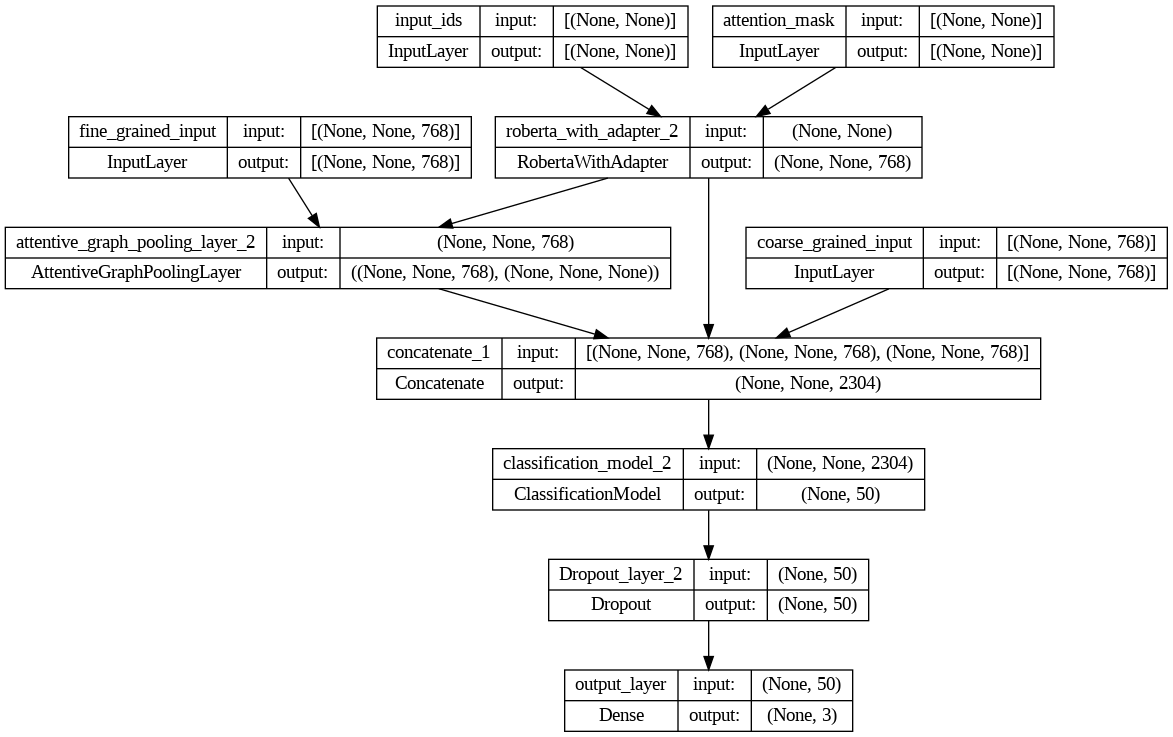

In [16]:
import tensorflow as tf
from transformers import TFRobertaModel, RobertaTokenizer
from tensorflow import keras
from keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, Concatenate
from keras.models import Model
from keras.optimizers import Nadam
from keras.utils import plot_model

model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)

class ClassificationModel(tf.keras.Model):
    def __init__(self, max_sequence_length, combined_embedding_dim):
        super(ClassificationModel, self).__init__()
        self.conv1d = Conv1D(filters=256, kernel_size=5, activation='relu', name='Conv1D_layer')
        self.max_pooling = MaxPooling1D(pool_size=2, name='MaxPooling_layer')
        self.bilstm = Bidirectional(LSTM(100, return_sequences=True, name='BiLSTM_layer'))
        self.attention = tf.keras.layers.Attention(name='Attention_layer')
        self.global_max_pooling = GlobalMaxPooling1D(name='Attention_Pooling_layer')
        self.dense1 = Dense(100, activation='relu', name='Dense_layer_1')
        self.dropout1 = Dropout(0.6, name='Dropout_layer_1')
        self.dense2 = Dense(50, activation='relu', name='Dense_layer_2')

    def call(self, inputs):
        x = self.conv1d(inputs)
        x = self.max_pooling(x)
        x = self.bilstm(x)
        attention_output = self.attention([x, x])
        x = self.global_max_pooling(attention_output)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        return x

class AdapterLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, adapter_dim):
        super(AdapterLayer, self).__init__()
        self.linear1 = tf.keras.layers.Dense(adapter_dim, activation='relu')
        self.linear2 = tf.keras.layers.Dense(input_dim)

    def call(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

class RobertaWithAdapter(tf.keras.Model):
    def __init__(self, model_name, adapter_dim):
        super(RobertaWithAdapter, self).__init__()
        self.roberta = TFRobertaModel.from_pretrained(model_name)
        self.adapter = AdapterLayer(self.roberta.config.hidden_size, adapter_dim)

    def call(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        adapter_output = self.adapter(sequence_output)
        return adapter_output

class AttentiveGraphPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(AttentiveGraphPoolingLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.WQ = tf.keras.layers.Dense(hidden_dim)
        self.WK = tf.keras.layers.Dense(hidden_dim)
        self.WV = tf.keras.layers.Dense(hidden_dim)

    def call(self, h, c):
        batch_size = tf.shape(h)[0]
        seq_length_h = tf.shape(h)[1]
        seq_length_c = tf.shape(c)[1]

        Q = tf.expand_dims(self.WQ(h), axis=1)
        K = tf.expand_dims(self.WK(c), axis=0)
        V = tf.expand_dims(self.WV(c), axis=0)

        attn_scores = tf.matmul(Q, K, transpose_b=True)
        attn_scores = attn_scores / tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32))

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)

        attended_values = tf.matmul(attn_weights, V)
        attended_values = tf.squeeze(attended_values, axis=1)

        return attended_values, tf.squeeze(attn_weights, axis=1)


input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
fine_grained_input = Input(shape=(None, 768), dtype=tf.float32, name='fine_grained_input')
coarse_grained_input = Input(shape=(None, 768), dtype=tf.float32, name='coarse_grained_input')


roberta_with_adapter = RobertaWithAdapter(model_name, adapter_dim=64)
attention_layer = AttentiveGraphPoolingLayer(hidden_dim=768)
max_seq = roberta_with_adapter.roberta.config.max_position_embeddings
class_model = ClassificationModel(max_sequence_length=max_seq, combined_embedding_dim=768)


roberta_output = roberta_with_adapter(input_ids=input_ids, attention_mask=attention_mask)
attention_output, _ = attention_layer(fine_grained_input, roberta_output)


concatenated_input = Concatenate()([roberta_output, attention_output, coarse_grained_input])

output_layer = class_model(concatenated_input)
dropout2 = Dropout(0.5, name='Dropout_layer_2')(output_layer)
output_layer = Dense(3, activation='softmax', name='output_layer')(dropout2)


final_model = Model(inputs=[input_ids, attention_mask, fine_grained_input, coarse_grained_input], outputs=output_layer)


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
final_model.compile(optimizer=Nadam(learning_rate=0.001), loss=loss_fn, metrics=['accuracy'])

final_model.summary()
plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
input_text = "Microsoft is world's largest software comapny"
roberta_input ,contextual_vectors_coarse , contextual_vectors_fine = get_input(input_text , model , tokenizer)
print(roberta_input)